In [4]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')

### <span style="color:cyan"><i>Data Cleaning</i></span>

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import  StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression

In [7]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')

In [59]:
df = pd.read_csv('https://raw.githubusercontent.com/SumanGouda/Scikit-Learn-/refs/heads/main/PROJECT/HEART%20DISEASE/heart_disease_uci.csv')

categorical_cols = ['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
numerical_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
zero_nan_cols = ['chol']
log_cols = ['chol', 'ca']
ordinal_columns = ['cp', 'restecg', 'slope', 'thal']
normal_cat_cols = ['sex', 'dataset', 'fbs', 'exang']

X = df[categorical_cols + numerical_cols]
y = df['num']

In [60]:
from sklearn.base import BaseEstimator, TransformerMixin, OneToOneFeatureMixin

class LogTransformer(OneToOneFeatureMixin, BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  # Does nothing during fitting
    
    def transform(self, X):
        return np.log1p(X)  # Applies log(1 + x) to each value

class ZeroToNanTransformer(OneToOneFeatureMixin, BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns  # List of columns to process (e.g., ['chol', 'ca'])
    
    def fit(self, X, y=None):
        return self  # No fitting required
    
    def transform(self, X):
        X = X.copy()
        if self.columns:
            for col in self.columns:
                X[col] = X[col].replace(0, np.nan)  # Replace 0 with NaN
        return X


In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn import set_config
set_config(transform_output="pandas")

In [63]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Single ColumnTransformer for all steps
preprocessor = ColumnTransformer([
    
    # Step 1: Impute categorical
    ('cat', SimpleImputer(strategy='most_frequent'), categorical_cols),
    
    # Step 2: Impute numerical (including zero → NaN columns)
    ('num', Pipeline([
        ('zero_to_nan', ZeroToNanTransformer(columns=zero_nan_cols)),
        ('impute', KNNImputer(n_neighbors=3))
    ]), numerical_cols + zero_nan_cols),
    
    # Step 3: Log transform
    ('log', LogTransformer(), log_cols),
    
    # Step 4: One-hot encode
    ('ohe', OneHotEncoder(drop='first', sparse_output=False), normal_cat_cols),
    
    # Step 5: Ordinal encode with imputation
        ('ordinal', Pipeline([
            ('impute', SimpleImputer(strategy='most_frequent')),  # First impute missing values
            ('encode', OrdinalEncoder(categories=[
                ['asymptomatic', 'non-anginal', 'atypical angina', 'typical angina'],
                ['normal', 'st-t abnormality', 'lv hypertrophy'],
                ['flat', 'upsloping', 'downsloping'],
                ['normal', 'reversable defect', 'fixed defect']
            ]))
        ]), ordinal_columns),
    
    # Step 6: Scale
    ('scaler', StandardScaler(), ['age', 'trestbps', 'chol', 'thalch']),
    ('minmax', MinMaxScaler(), ['oldpeak', 'ca'])
], remainder='passthrough')

# Final pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

In [ ]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

In [43]:
trf2_X_transformed = trf2.fit_transform(X_train)

# Display first 5 rows
trf2_X_transformed.head()

,cat__sex,cat__dataset,cat__cp,cat__fbs,cat__restecg,cat__exang,cat__slope,cat__thal,num__age,num__trestbps,num__chol,num__thalch,num__oldpeak,num__ca,num__chol
880,Male,VA Long Beach,asymptomatic,False,st-t abnormality,True,flat,normal,62.0,139.333333,170.000000,120.000000,3.000000,0.333333,170.000000
457,Male,Hungary,non-anginal,False,normal,False,flat,normal,54.0,150.000000,211.666667,122.000000,0.000000,0.333333,211.666667
797,Male,VA Long Beach,non-anginal,False,normal,False,flat,normal,51.0,150.000000,339.000000,130.333333,1.333333,0.000000,339.000000
25,Female,Cleveland,non-anginal,False,normal,False,flat,normal,50.0,120.000000,219.000000,158.000000,1.600000,0.000000,219.000000
84,Male,Cleveland,atypical angina,False,normal,False,upsloping,normal,52.0,120.000000,325.000000,172.000000,0.200000,0.000000,325.000000


In [46]:
trf3 = ColumnTransformer([                          # Step 3: Log transform
    ('log', LogTransformer(), log_cols)
], remainder='passthrough')

In [47]:
trf3_X_transformed = trf3.fit_transform(X_train)

# Display first 5 rows
trf3_X_transformed.head()

,log__chol,log__ca,remainder__sex,remainder__dataset,remainder__cp,remainder__fbs,remainder__restecg,remainder__exang,remainder__slope,remainder__thal,remainder__age,remainder__trestbps,remainder__thalch,remainder__oldpeak
880,5.141664,NaN,Male,VA Long Beach,asymptomatic,False,st-t abnormality,True,NaN,NaN,62,NaN,120.0,3.0
457,NaN,NaN,Male,Hungary,non-anginal,False,normal,False,NaN,NaN,54,150.0,122.0,0.0
797,5.828946,NaN,Male,VA Long Beach,non-anginal,False,normal,NaN,NaN,NaN,51,NaN,NaN,NaN
25,5.393628,0.0,Female,Cleveland,non-anginal,False,normal,False,flat,normal,50,120.0,158.0,1.6
84,5.786897,0.0,Male,Cleveland,atypical angina,False,normal,False,upsloping,normal,52,120.0,172.0,0.2


In [34]:
trf4 = ColumnTransformer([                          # Step 4: One-hot encode
    ('ohe', OneHotEncoder(drop='first'), normal_cat_cols)
], remainder='passthrough').set_output(transform="pandas")

In [35]:
trf5 = ColumnTransformer([                          # Step 5: Ordinal encode
    ('ordinal', OrdinalEncoder(categories=[
        ['asymptomatic', 'non-anginal', 'atypical angina', 'typical angina'],
        ['normal', 'st-t abnormality', 'lv hypertrophy'],
        ['flat', 'upsloping', 'downsloping'],
        ['normal', 'reversible defect', 'fixed defect']
    ]), oridnal_columns)
], remainder='passthrough').set_output(transform="pandas")

In [36]:
trf6 = ColumnTransformer([                          # Step 6: Scale
    ('scaler', StandardScaler(), ['age', 'trestbps', 'chol', 'thalch']),
    ('minmax', MinMaxScaler(), ['oldpeak', 'ca'])
], remainder='passthrough').set_output(transform="pandas")

In [37]:
# Full pipeline
pipe = Pipeline([
    ('zero_to_nan', trf1),  # Step 1
    ('impute', trf2),       # Step 2
    ('log', trf3),          # Step 3
    ('ohe', trf4),          # Step 4
    ('ordinal', trf5),      # Step 5
    ('scale', trf6),        # Step 6
    ('model', LinearRegression())
])

ValueError: A given column is not a column of the dataframe

In [51]:
X_train['ca'].describe()

count    250.000000
mean       0.688000
std        0.960388
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        3.000000
Name: ca, dtype: float64

In [37]:
X_train = X_train[X_train['trestbps'] > 0]  # Keep only valid BP values

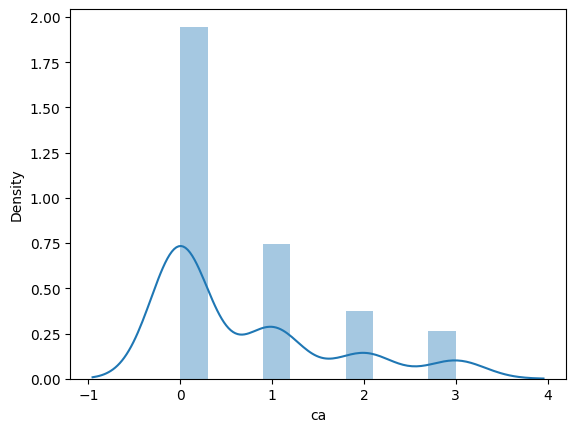

In [50]:
import seaborn as sns 
sns.distplot(X_train['ca'])
plt.show()

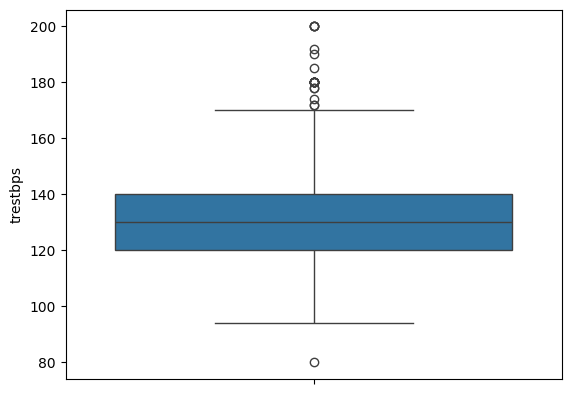

In [39]:
sns.boxplot(X_train['trestbps'])
plt.show()